In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from decoder import decoder
from plsda import PLSDA
from decoder_preprocessor import preprocess_single_trial_data

**Note**: This project is currently a work in progress. Stay tuned for more documentation and usage tutorials as I get everything polished and ready. I am currently working on implementing  methods for intrinsic firing rate estimation from single trial data as well as implementing deep learning frameworks for working with trial averaged data.

## Data

Data for this demonstration is available at: https://doi.org/10.6084/m9.figshare.30194719.v1

In [2]:
# The needed filed paths

lgn_data_path = './necessary_files/lgn_data.pkl'
v1_data_path = './necessary_files/v1_data.pkl'
parameter_map_path = './necessary_files/parameter_map.pkl'

## Load and preprocess the data

In [3]:
preprocess = preprocess_single_trial_data()
parameter_map = pd.read_pickle(parameter_map_path)
sfs = parameter_map['Spatial Freq'].unique()[1:]

n_trials = 50 # number of repeats per stimulus
n_samples = 500 # number of repeats x number of stimulus conditions (10)

### The dependent variable (Y: Spatial frequency of the visual stimulus)

In [4]:
# generate the stimulus condition label for each trial

# Generate a list of labels to match the number of trials for each class
Y_orig = preprocess.generate_class_labels(parameter_map, 'Spatial Freq', n_trials, slc = slice(1, None))

# One hot encode the labels
df = pd.DataFrame({
    'SF': Y_orig
})

Y_dum = pd.get_dummies(df, columns = ['SF']).values
n_classes = Y_dum.shape[1]

# The label of each column
labels = (parameter_map['Spatial Freq'].unique()[1:]*100).astype(int)

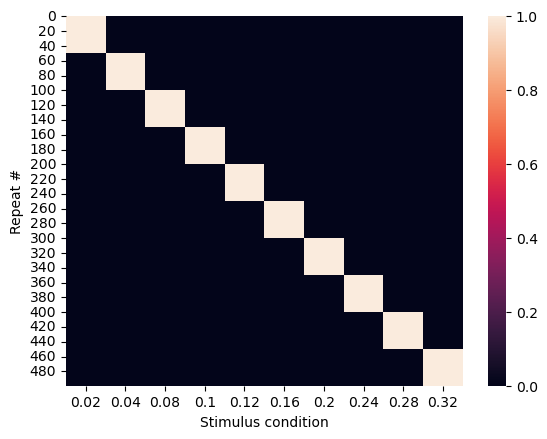

In [5]:
fig, ax = plt.subplots()
sns.heatmap(Y_dum)
ax.set_ylabel("Repeat #")
ax.set_xlabel("Stimulus condition")
ax.set_xticklabels(sfs)
plt.show()

### The independent varible (X: Neural activity in response to the visual stimulus)

In [6]:
# dLGN Data

# load the data 
with open(lgn_data_path, 'rb') as f:
    Xlgn_original = pickle.load(f)
    n_trials, n_avg = 250, 5
    Xlgn = preprocess.get_trial_averaged_samples(
            Xlgn_original, n_stim = 10, n_trials = 250, n_avg = n_avg
        )
    n_trials = int(n_trials/n_avg)

In [7]:
# V1 Data
with open(v1_data_path, 'rb') as f:
    Xv1_original = pickle.load(f)
    n_trials, n_avg = 250, 5
    Xv1 = preprocess.get_trial_averaged_samples(
            Xv1_original, n_stim = 10, n_trials = 250, n_avg = n_avg
        )
    n_trials = int(n_trials/n_avg)

In [8]:
print(f"Dim0 = {Xlgn.shape[0]}, the number of neurons in the population.")
print(f"Dim1 = {Xlgn.shape[1]}, the number of stimulus repeats in the experiment.")
print(f"Dim2 = {Xlgn.shape[2]}, the duration (ms) of the stimulus-triggered neural response")

Dim0 = 237, the number of neurons in the population.
Dim1 = 500, the number of stimulus repeats in the experiment.
Dim2 = 250, the duration (ms) of the stimulus-triggered neural response


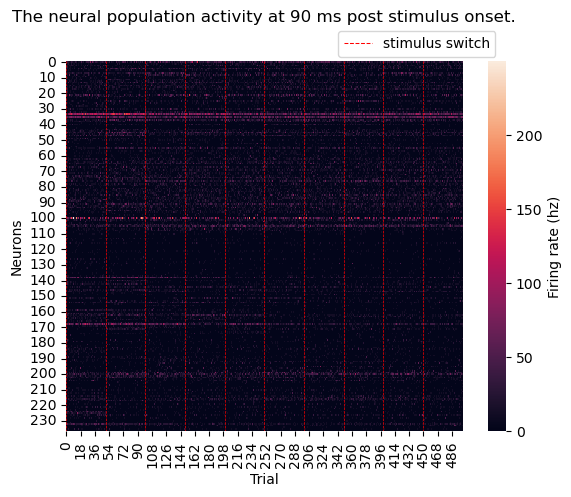

In [9]:
fig, ax = plt.subplots()
t = 90
sns.heatmap(Xlgn[:,:,t], cbar_kws={'label': 'Firing rate (hz)'})
for i in range(0,550,50):
    ax.plot([i]*250, np.arange(250), '--', color = 'red', linewidth = 0.5)
    if i == 500:
        ax.plot([i]*250, np.arange(250), '--', color = 'red', linewidth = 0.75, label = 'stimulus switch')
ax.set_title("The neural population activity at 90 ms post stimulus onset.", y = 1.085)
ax.set_ylabel("Neurons")
ax.set_xlabel("Trial")
ax.legend(bbox_to_anchor = (1.1,1.1), loc = 'upper right')

## Basic usage

In [10]:
# initialize an instance of the decoder

d = decoder(
    Xlgn, Y_dum.T, # independent (X) and dependent (Y) variables
    model = PLSDA(n_components = 10), # the type of ML model to use for decoding
    labels = (sfs*100).astype(int) # labels to convert back from one-hot encoding
)
d

In [11]:
# split the data into training and testing samples

d.train_test_split(
    n_stim = 10, # number of stimulus classes
    trials_per_stim = 50, # number of trials per class
    test_size = 0.2
)

In [12]:
# fit and score the model at a particular timepoint

out = d.fit(
    t = 110, # timepoint to predict from the neural response
)

score, confusion_matrix = d.score(110)
print(f'Prediction accuracy = {score*100}%')

Prediction accuracy = 46.0%


[Text(0, 0.5, '0.02'),
 Text(0, 1.5, '0.04'),
 Text(0, 2.5, '0.08'),
 Text(0, 3.5, '0.1'),
 Text(0, 4.5, '0.12'),
 Text(0, 5.5, '0.16'),
 Text(0, 6.5, '0.2'),
 Text(0, 7.5, '0.24'),
 Text(0, 8.5, '0.28'),
 Text(0, 9.5, '0.32')]

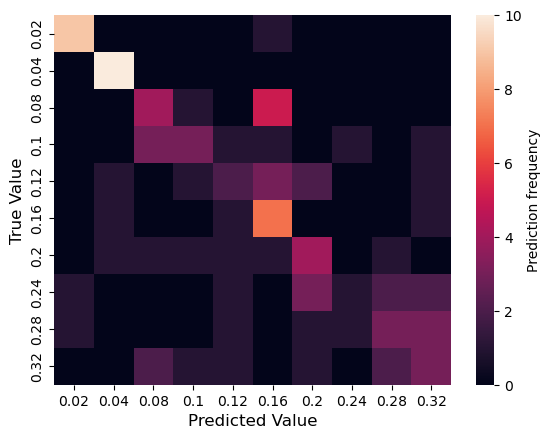

In [13]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix, cbar_kws={'label': 'Prediction frequency'})
ax.set_xlabel('Predicted Value', fontsize = 12)
ax.set_xticklabels(sfs)
ax.set_ylabel('True Value', fontsize = 12)
ax.set_yticklabels(sfs)

## Embedding timelags into the feature or sample space

In [14]:
# initialize an instance of the decoder
d = decoder(
    Xlgn, Y_dum.T, 
    model = PLSDA(n_components = 10),
    labels = (sfs*100).astype(int)
)

# split the data into training and testing samples
d.train_test_split(
    n_stim = 10,
    trials_per_stim = 50,
    test_size = 0.2
)


In [15]:
# fit and score the model at a particular timepoint
out = d.fit(
    t = 110,
    
    # embedding arguments are passes as keyword arguments
    embedding_params = {
        'space': 'feature', # enter 'feature' to embed timelags into the feature space
        'lag': 20 # the number of lags to embed
    }
)

In [16]:
# feature embedding significantly improves the decoder accuracy 

score, confusion_matrix = d.score(110)
print(f'Prediction accuracy = {score*100}%')

Prediction accuracy = 67.0%


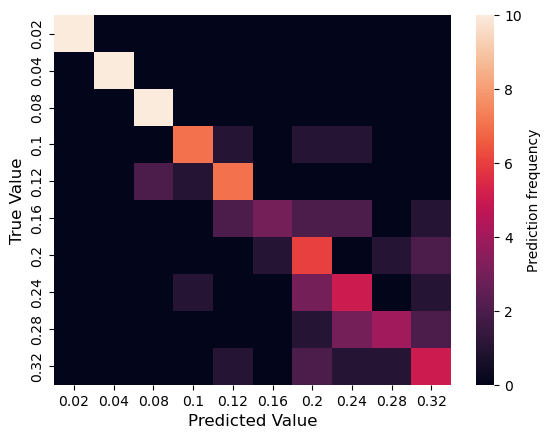

In [17]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix, cbar_kws={'label': 'Prediction frequency'})
ax.set_xlabel('Predicted Value', fontsize = 12)
ax.set_xticklabels(sfs)
ax.set_ylabel('True Value', fontsize = 12)
ax.set_yticklabels(sfs)
plt.show()

In [18]:
## To embed timelags into the sample space instead, change the 'space' keyword to 'sample'

# initialize an instance of the decoder
d = decoder(
    Xlgn, Y_dum.T, 
    model = PLSDA(n_components = 10),
    labels = (sfs*100).astype(int)
)

# split the data into training and testing samples
d.train_test_split(
    n_stim = 10,
    trials_per_stim = 50,
    test_size = 0.2
)

# fit and score the model at a particular timepoint
out = d.fit(
    t = 110,
    embedding_params = {
        'space': 'sample', # enter 'sample' to embed timelags into the sample space
        'lag': 20
    }
)

score, confusion_matrix = d.score(110)
print(f'Prediction accuracy = {score*100}%')

Prediction accuracy = 53.9047619047619%


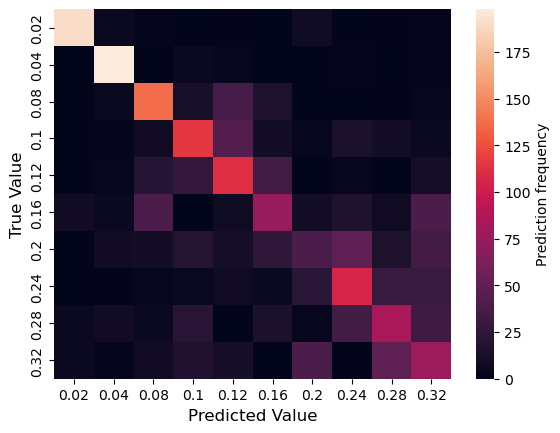

In [19]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix, cbar_kws={'label': 'Prediction frequency'})
ax.set_xlabel('Predicted Value', fontsize = 12)
ax.set_xticklabels(sfs)
ax.set_ylabel('True Value', fontsize = 12)
ax.set_yticklabels(sfs)
plt.show()

## Cross validation

In [20]:
## To perform cross validation, use the crose_validate method

# initialize an instance of the decoder
d = decoder(
    Xlgn, Y_dum.T, 
    model = PLSDA(n_components = 10),
    labels = (sfs*100).astype(int)
)

# split the data into training and testing samples
d.train_test_split(
    n_stim = 10,
    trials_per_stim = 50,
    test_size = 0.2
)

# the cross_validate method returns a tuple with 3
# elements: a list of the model initialized for each
# fold, a list of scores from each fold, and a list 
# of confusion matrices for each fold. They embedding
# parameters keyword arguemnts can still be passes like 
# as the would be in the typical fit method.
result = d.cross_validate(
    k = 10, # the number of folds
    t = 110,
    embedding_params = {
        'space': 'feature',
        'lag': 20
    }
)

In [21]:
print(fr'Prediction accuracy = {np.mean(result[1])*100}% ± {(np.array(result[1])*100).std()/np.sqrt(10)}')

Prediction accuracy = 65.99999999999999% ± 2.5544079548889598


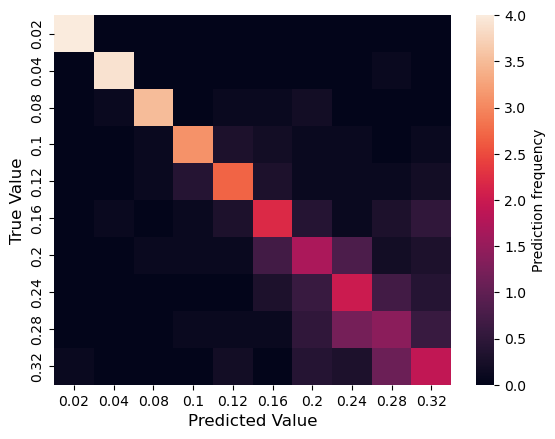

In [22]:
fig, ax = plt.subplots()
sns.heatmap(np.array(result[2]).mean(0), cbar_kws={'label': 'Prediction frequency'})
ax.set_xlabel('Predicted Value', fontsize = 12)
ax.set_xticklabels(sfs)
ax.set_ylabel('True Value', fontsize = 12)
ax.set_yticklabels(sfs)
plt.show()

## Continuous decoding

In [23]:
## Decode continuously from the activity of two different brain areas using feature embedding

## intialize and run the decoder on Lateral Geniculate Nucleus data
dlgn = decoder(
    Xlgn, Y_dum.T,
    model = PLSDA(n_components = 10),  
    boost = False,
    labels = (sfs*100).astype(int)
)

dlgn.train_test_split(
    n_stim = 10,
    trials_per_stim = 50,
    test_size = 0.2
)

lgn_result = []
for t in range(50, 151):
    out = dlgn.cross_validate(
        k = 10, 
        t = t, 
        embedding_params = {
            'space': 'feature',
            'lag': 20
        }
    )
    lgn_result.append(out)

## intialize and run the decoder on Visual Cortex data
dv1 = decoder(
    Xv1, Y_dum.T,
    model = PLSDA(n_components = 10),  
    boost = False,
    labels = (sfs*100).astype(int)
)

dv1.train_test_split(
    n_stim = 10,
    trials_per_stim = 50,
    test_size = 0.2
)

v1_result = []
for t in range(50, 151):
    out = dv1.cross_validate(
        k = 10, 
        t = t,
        embedding_params = {
            'space': 'feature',
            'lag': 20
        }
    )
    v1_result.append(out)

/home/neurolab/.conda/envs/neurophys/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/neurolab/.conda/envs/neurophys/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/neurolab/.conda/envs/neurophys/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/neurolab/.conda/envs/neurophys/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/neurolab/.conda/envs/neurophys/lib/pyt

/tmp/ipykernel_559615/1919894394.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(30,170,20))


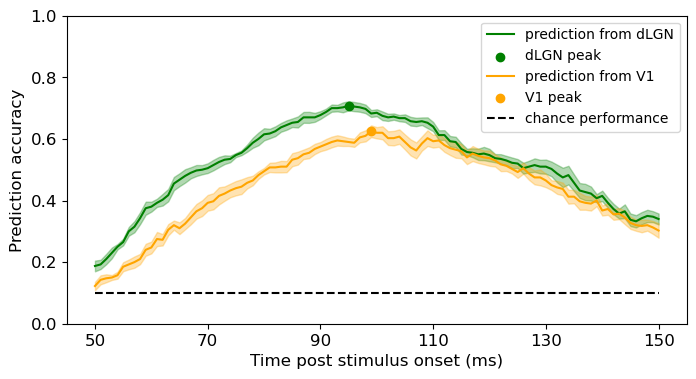

In [60]:
fig, ax = plt.subplots(figsize = (8,4))

ax.plot(lgn_scores.mean(1), color = 'green', label = 'prediction from dLGN')
ax.scatter(
    np.where(lgn_scores.mean(1) == lgn_scores.mean(1).max())[0][0],
    lgn_scores.mean(1).max(), color = 'green', label = 'dLGN peak'
)
ax.fill_between(
    np.arange(101),
    lgn_scores.mean(1) - (lgn_scores.std(1)/np.sqrt(lgn_scores.shape[1])),
    lgn_scores.mean(1) + (lgn_scores.std(1)/np.sqrt(lgn_scores.shape[1])),
    lgn_scores.mean(1), color = 'green', alpha = 0.3
    
)
ax.plot(v1_scores.mean(1), color = 'orange', label = 'prediction from V1')
ax.scatter(
    np.where(v1_scores.mean(1) == v1_scores.mean(1).max())[0][0],
    v1_scores.mean(1).max(), color = 'orange', label = 'V1 peak'
)
ax.fill_between(
    np.arange(101),
    v1_scores.mean(1) - (v1_scores.std(1)/np.sqrt(v1_scores.shape[1])),
    v1_scores.mean(1) + (v1_scores.std(1)/np.sqrt(v1_scores.shape[1])),
    v1_scores.mean(1), color = 'orange', alpha = 0.3
    
)
ax.set_xticklabels(np.arange(30,170,20))
ax.set_ylim(0,1)
ax.tick_params(labelsize = 12)
ax.set_xlabel("Time post stimulus onset (ms)", fontsize = 12)
ax.set_ylabel("Prediction accuracy", fontsize = 12)
ax.plot(np.arange(101), [0.1]*101, '--', color = 'black', label = 'chance performance')
ax.legend()